Examine simulated spectra where redrock fails

In [1]:
import os
import numpy as np 
from scipy.signal import medfilt
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM
# -- desihub -- 
import redrock as RedRock
from redrock.external import desi
from redrock import templates as rr_templates

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
templates_path = RedRock.templates.find_templates(None)
templates = {} 
for el in templates_path: 
    t = RedRock.templates.Template(filename=el)
    templates[t.full_type] = t

DEBUG: Using default redshift range 0.0050-1.6988 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-3.9968 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Carbon.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Ldwarf.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


Read in GAMA-legacy catalog in `field` region for the meta data

In [4]:
field = 'g15'
# read in GAMA-Legacy survey
cata = Cat.GamaLegacy()
gleg = cata.Read(field)
if field == 'g09': 
    nblocks = 26
elif field == 'g15': 
    nblocks = 64

In [5]:
redshift = gleg['gama-spec']['z']
ngal = len(redshift)
print('%i galaxies total' % ngal)

63004 galaxies total


In [6]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

Read in dark sky simulated spectra for galaxy `i_gal`

In [7]:
i_block = 5
dir_redrock = ''.join([UT.dat_dir(), 'redrock/'])
dir_spectra = ''.join([UT.dat_dir(), 'spectra/'])

f_z_dark = ''.join([dir_redrock, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([dir_spectra, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')

f_z_bright = ''.join([dir_redrock, 
                      'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zbright_data = fits.open(f_z_bright)[1].data

f_i_bright = ''.join([dir_spectra, 
                      'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_bright = np.loadtxt(f_i_bright, unpack=True, usecols=[0], dtype='i')

In [8]:
assert np.array_equal(i_dark, i_bright)
print('%i simulated spectra with redrock redshifts' % len(zdark_data['Z']))

1000 simulated spectra with redrock redshifts


Read in simulated spectra

In [9]:
f_spec_dark = ''.join([dir_spectra, 
                       'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])

f_spec_bright = ''.join([dir_spectra, 
                         'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])
target_bright = desi.DistTargetsDESI(f_spec_bright)._my_data
target_dark = desi.DistTargetsDESI(f_spec_dark)._my_data

Read in accompanying redrock output data

In [10]:
f_rr_dark = ''.join([dir_redrock, 
                     'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.h5'])
f_rr_bright = ''.join([UT.dat_dir(), 'redrock/', 
                     'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.h5'])
zscan_dark, zfit_dark = RedRock.results.read_zscan(f_rr_dark)
zscan_bright, zfit_bright = RedRock.results.read_zscan(f_rr_bright)

In [11]:
def GAMA_subsample(index, colour='C0'): 
    fig = plt.figure(figsize=(15, 4))
    ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, y, ylbl in zip(range(1,4), ys, ylbls):
        sub = fig.add_subplot(1,3,i)
        sub.scatter(r_absmag_gama, y, c='k', s=1.)
        sub.scatter(r_absmag_gama[index], y[index], c=colour, s=1.)
        if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
        sub.set_xlim([-14., -24])
        sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
        sub.set_ylim([-0.2, 1.6])
    fig.subplots_adjust(wspace=0.3)

    fig = plt.figure(figsize=(15, 4))
    xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
        sub = fig.add_subplot(1, len(xs), i)
        hasha = (gama_ha > 0)
        sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k')
        sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
        hasha = (gama_ha[index] > 0)
        sub.scatter(x[index][hasha], gama_ha[index][hasha], c=colour, s=1.)
        sub.scatter(x[index][~hasha], np.repeat(1e-2, np.sum(~hasha)), c=colour, s=1.)
        sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
        sub.set_xlim([-0.2, 2.])
        if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
        sub.set_ylim([5e-3, 2e4])
        sub.set_yscale('log')
    fig.subplots_adjust(wspace=0.3)
    return None 

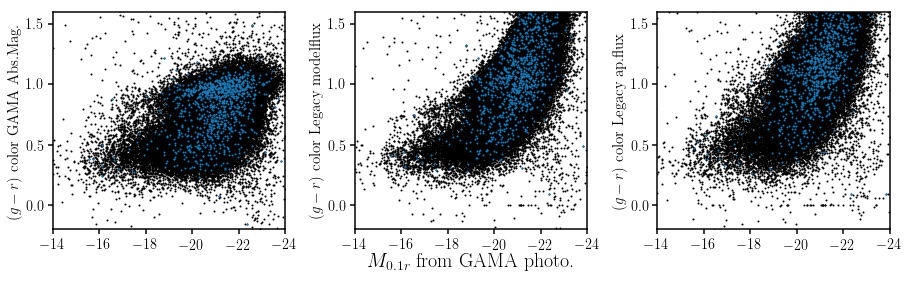

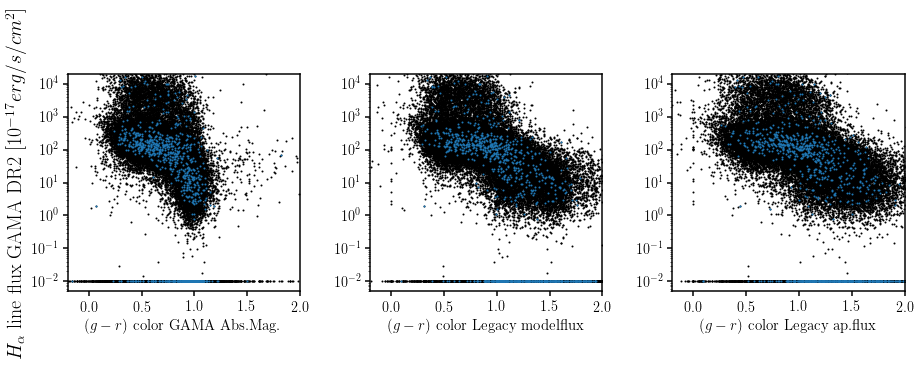

In [12]:
GAMA_subsample(i_dark, colour='C0')

Now lets identify the galaxies that fails to get correct redshifts from redrock

In [13]:
zfail_dark = (np.abs(redshift[i_dark] - zdark_data['Z'])/redshift[i_dark] > 0.003)
zfail_bright = (np.abs(redshift[i_dark] - zbright_data['Z'])/redshift[i_dark] > 0.003)
zfail_both = (zfail_dark & zfail_bright)
print('for %i galaxies with dark sky redrock fails' % np.sum(zfail_dark))
print('for %i galaxies with bright sky redrock fails' % np.sum(zfail_bright))
print('for %i galaxies redrock fails for both sky' % np.sum(zfail_both))

for 86 galaxies with dark sky redrock fails
for 95 galaxies with bright sky redrock fails
for 79 galaxies redrock fails for both sky


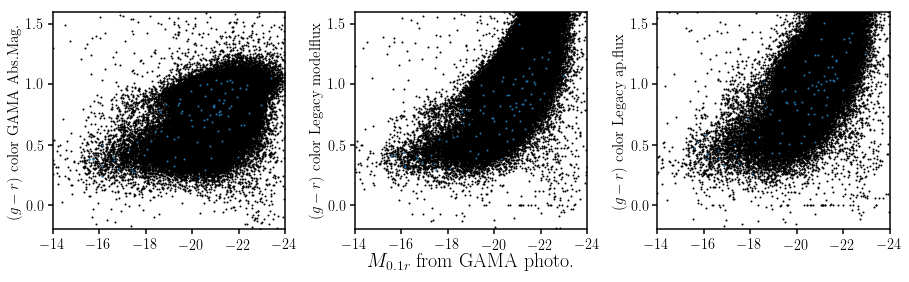

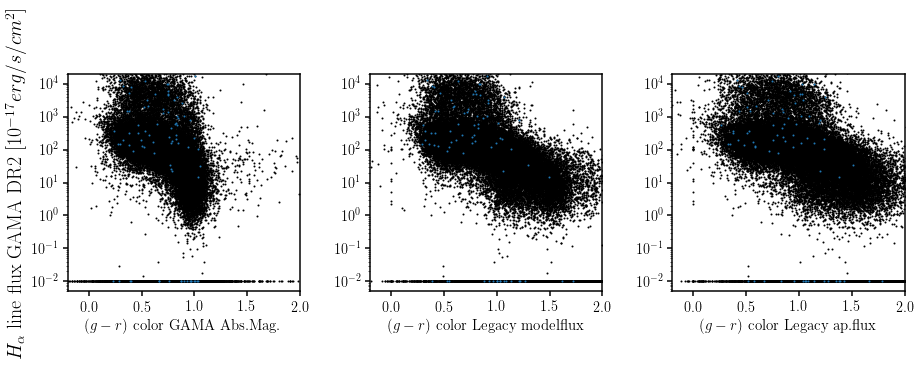

In [14]:
GAMA_subsample(i_dark[zfail_dark], colour='C0')

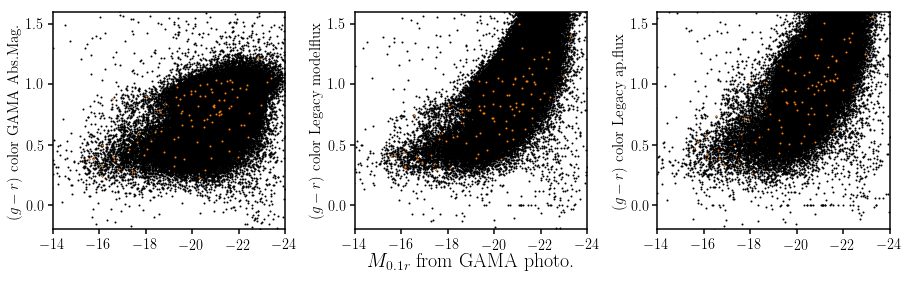

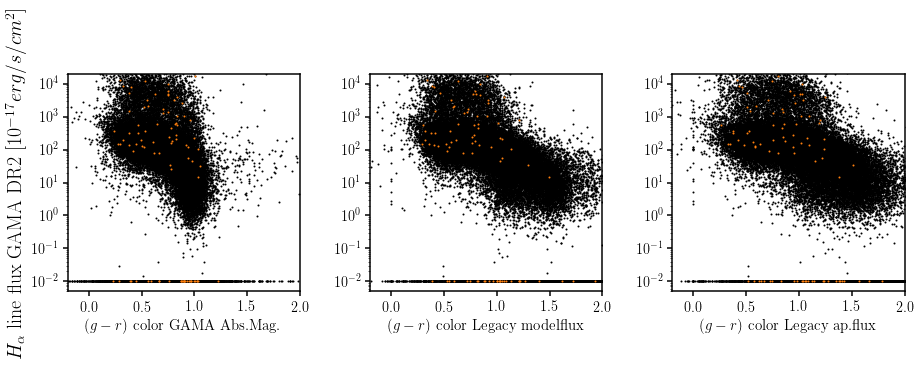

In [15]:
GAMA_subsample(i_dark[zfail_bright], colour='C1')

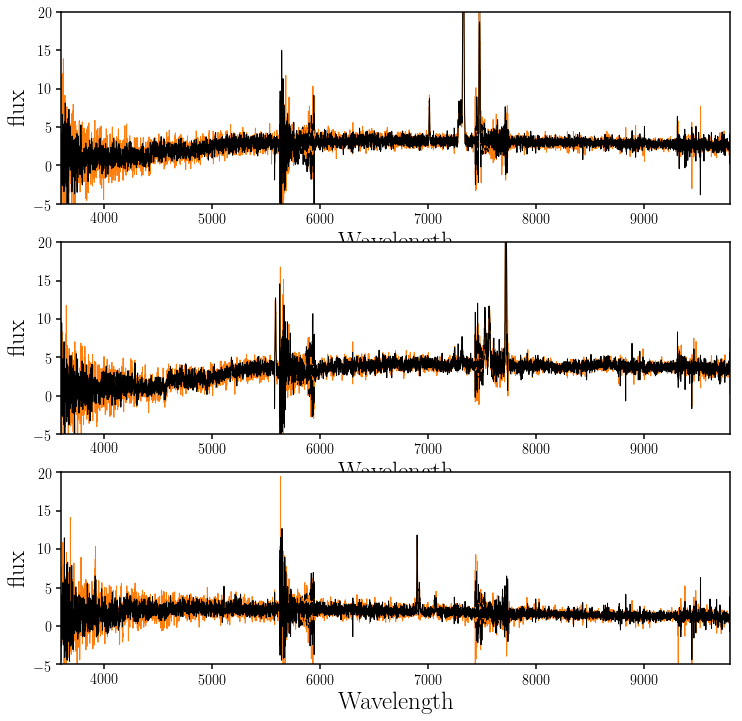

In [16]:
fig = plt.figure(figsize=(12,12))
for ii in range(3): 
    sub = fig.add_subplot(3,1,ii+1)
    i_targ = np.arange(len(i_dark))[zfail_both][ii]
    for s_dark, s_bright in zip(target_dark[i_targ].spectra, target_bright[i_targ].spectra):
        sub.plot(s_bright.wave, s_bright.flux, c='C1', lw=1) #s=0.5)
        sub.plot(s_dark.wave, s_dark.flux, c='k', lw=1) #s=0.5)

    sub.set_xlabel('Wavelength', fontsize=25)
    sub.set_xlim([3600., 9800.])
    sub.set_ylabel('flux', fontsize=25)
    sub.set_ylim([-5., 20])

here's some code that plots redrock outputs

In [17]:
def plotspec(target, zscan, zfit, xrange0=None, yrange0=None, xrange1=None, yrange1=None): 
    zfit_i = zfit[zfit['targetid'] == target.id]
    zz = zfit_i[zfit_i['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    fig = plt.figure(figsize=(12,8)) 
    _ax1 = fig.add_subplot(211)
    for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
        if spectype in zscan[target.id]:
            zx = zscan[target.id][spectype]
            _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                      label='_none_')
            _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                      label=spectype)
    _ax1.plot(zfit_i['z'], zfit_i['chi2'], 'r.', label='_none_')
    if xrange0 is not None: _ax1.set_xlim(xrange0)
    if yrange0 is not None: _ax1.set_ylim(yrange0)
    for row in zfit_i: 
        if xrange0 is not None or yrange0 is not None:
            if xrange0 is not None: xif = (row['z'] > xrange0[0]) & (row['z'] < xrange0[1])
            else: xif = True
            if yrange0 is not None: yif = (row['chi2'] > yrange0[0]) & (row['chi2'] < yrange0[1])
            else: yif = True
            if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
        else:
            _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
    _ax1.axvline(zz['z'], color='k', alpha=0.1)
    _ax1.axhline(zz['chi2'], color='k', alpha=0.1)
    _ax1.legend()
    _ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id, zz['z'], zz['spectype']))
    _ax1.set_ylabel(r'$\chi^2$', fontsize=25)
    _ax1.set_xlabel('redshift', fontsize=25)
    
    _ax2 = fig.add_subplot(212)        
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        isbad = (spec.ivar == 0)
        ## model[isbad] = mx[isbad]
        flux[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(flux, 1), alpha=0.5)
        _ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), 'k-', alpha=0.8)

        ymin = min(ymin, np.percentile(flux[~isbad], 1))
        ymax = max(ymax, np.percentile(flux[~isbad], 99), np.max(model)*1.05)

    #- Label object type and redshift
    label = 'znum {} {} z={:.3f}'.format(0, tp.full_type, zz['z'])
    #print('target {} id {} {}'.format(self.itarget, target.id, label))
    ytext = ymin+0.9*(ymax-ymin)
    if xrange1 is not None: _ax2.text(xrange1[0], ytext, label)
    else: _ax2.text(3800, ytext, label)
    _ax2.set_ylim(ymin, ymax)
    _ax2.set_xlim(3500,10100)   
    _ax2.set_ylabel('flux', fontsize=25)
    _ax2.set_xlabel('wavelength [A]', fontsize=25)    
    fig.subplots_adjust(hspace=0.3)
    plt.show()
    return None

def chi2_lambda(target, zscan, zfit, xrange=None, yrange=None, sub=None, **plt_kwargs):
    ''' plot chi-squared as a function of wavelength 
    '''
    zfit_i = zfit[zfit['targetid'] == target.id]
    zz = zfit_i[zfit_i['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    if sub is None: 
        fig = plt.figure(figsize=(12,4)) 
        sub = fig.add_subplot(111)
    
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        ivar = spec.ivar.copy() 
        isbad = (spec.ivar == 0)
        chi2 = (flux - model)**2 * ivar
        ## model[isbad] = mx[isbad]
        chi2[isbad] = np.NaN
        sub.plot(spec.wave, chi2, **plt_kwargs) #medfilt(flux, 1), alpha=0.5)
        
        #_ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        #model[isbad] = np.NaN
        #_ax2.plot(spec.wave, medfilt(model, 1), 'k-', alpha=0.8)

        ymin = min(ymin, np.percentile(chi2[~isbad], 1))
        ymax = max(ymax, np.percentile(chi2[~isbad], 99), np.max(chi2)*1.05)

    #- Label object type and redshift
    label = 'znum {} {} z={:.3f}'.format(0, tp.full_type, zz['z'])
    if yrange is not None: ymin, ymax = yrange
    ytext = ymin+0.9*(ymax-ymin)
    if xrange is not None: sub.text(xrange[0], ytext, label)
    else: sub.text(3800, ytext, label)
    if yrange is not None: sub.set_ylim(yrange)
    else: sub.set_ylim(ymin, ymax)
    #sub.set_yscale('log')
    sub.set_xlim(3500,10100)   
    sub.set_ylabel('$\chi^2(\lambda)$', fontsize=25)
    sub.set_xlabel('wavelength [A]', fontsize=25)    
    if sub is None: 
        fig.subplots_adjust(hspace=0.3)
        plt.show()
    return sub

def chi2z(target, zscan, zfit, xranges=None, yranges=None):
    zfit_i = zfit[zfit['targetid'] == target.id]
    zz = zfit_i[zfit_i['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    fig = plt.figure(figsize=(4*len(xranges),4)) 
    for i in range(len(xranges)): 
        _ax1 = fig.add_subplot(1,len(xranges),i+1)
        for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
            if spectype in zscan[target.id]:
                zx = zscan[target.id][spectype]
                _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                          label='_none_')
                _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                          label=spectype)
        _ax1.plot(zfit['z'], zfit['chi2'], 'r.', label='_none_')
        if xranges is not None: _ax1.set_xlim(xranges[i])
        if yranges is not None: _ax1.set_ylim(yranges[i])
        for row in zfit_i: 
            if xranges is not None or yranges is not None:
                if xranges is not None: xif = (row['z'] > xranges[i][0]) & (row['z'] < xranges[i][1])
                else: xif = True
                if yranges is not None: yif = (row['chi2'] > yranges[i][0]) & (row['chi2'] < yranges[i][1])
                else: yif = True
                if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
            else:
                _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
        _ax1.axvline(zz['z'], color='k', alpha=0.1)
        _ax1.axhline(zz['chi2'], color='k', alpha=0.1)
        #_ax1.legend()
        _ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id, zz['z'], zz['spectype']))
        _ax1.set_xlabel('redshift', fontsize=25)
        if i == 0: _ax1.set_ylabel(r'$\chi^2$', fontsize=25)
    fig.subplots_adjust(wspace=0.3)
    plt.show()
    return None

i = 29 with z = 0.113004
w/ Dark Sky


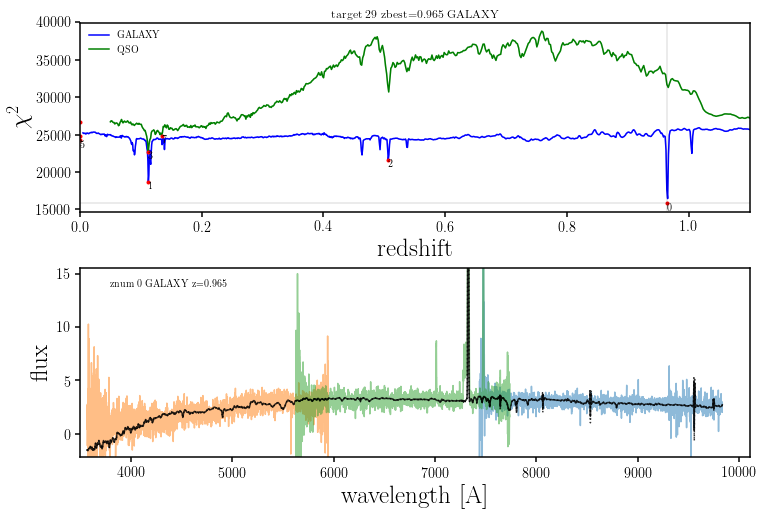

w/ Bright Sky


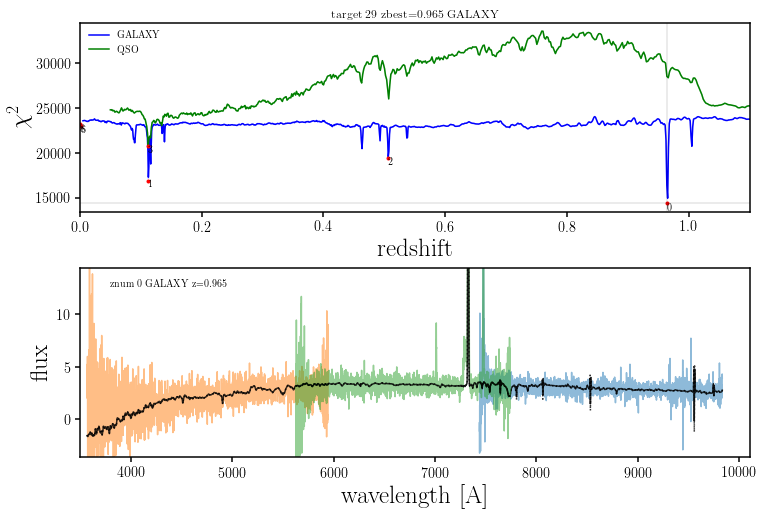

In [18]:
igal = np.arange(len(i_dark))[zfail_both][0]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))
print('w/ Dark Sky')
plotspec(target_dark[igal], zscan_dark, zfit_dark, xrange0=[0.,1.1])
print('w/ Bright Sky')
plotspec(target_bright[igal], zscan_bright, zfit_bright, xrange0=[0.,1.1])

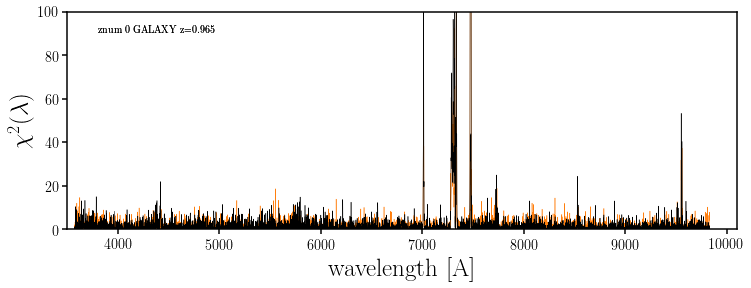

In [19]:
sub0 = chi2_lambda(target_bright[igal], zscan_bright, zfit_bright, yrange=[0.,100.], color='C1', lw=0.5)
chi2_lambda(target_dark[igal], zscan_dark, zfit_dark, yrange=[0.,100.], sub=sub0, color='k', lw=0.5)

In [20]:
zfail_onlybright = (~zfail_dark & zfail_bright)
zfail_onlydark = (zfail_dark & ~zfail_bright)
print('%i fail for only bright sky' % np.sum(zfail_onlybright))
print('%i fail for only dark sky' % np.sum(zfail_onlydark))

16 fail for only bright sky
7 fail for only dark sky


i = 350 with z = 0.253180
w/ Dark Sky


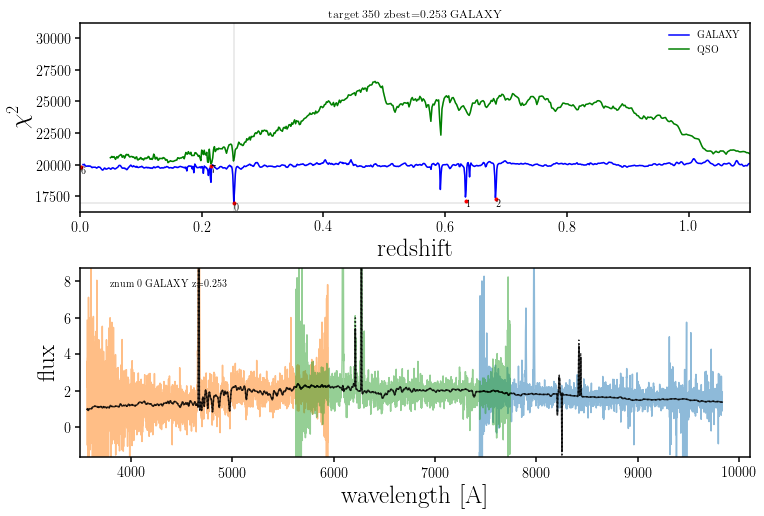

w/ Bright Sky


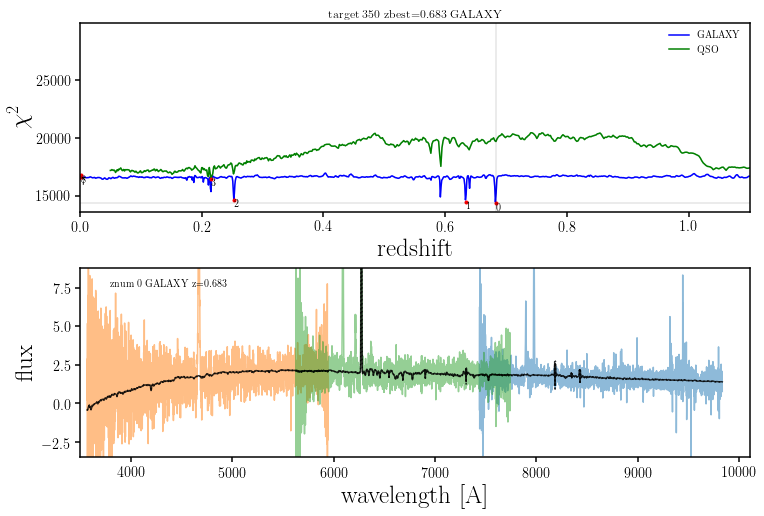

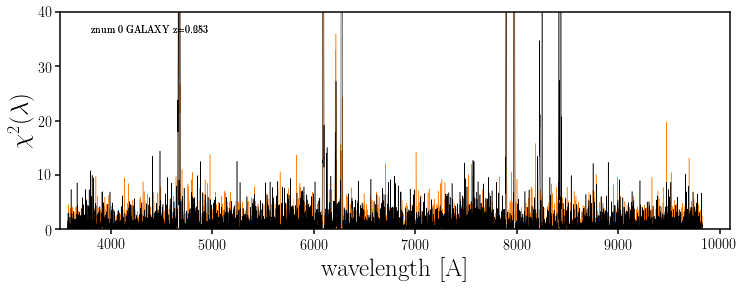

In [21]:
igal = np.arange(len(i_dark))[zfail_onlybright][0]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))
print('w/ Dark Sky')
plotspec(target_dark[igal], zscan_dark, zfit_dark, xrange0=[0.,1.1])
print('w/ Bright Sky')
plotspec(target_bright[igal], zscan_bright, zfit_bright, xrange0=[0.,1.1])

sub0 = chi2_lambda(target_bright[igal], zscan_bright, zfit_bright, yrange=[0.,40.], color='C1', lw=0.5)
chi2_lambda(target_dark[igal], zscan_dark, zfit_dark, yrange=[0.,40.], sub=sub0, color='k', lw=0.5)

i = 51 with z = 0.136221
w/ Dark Sky


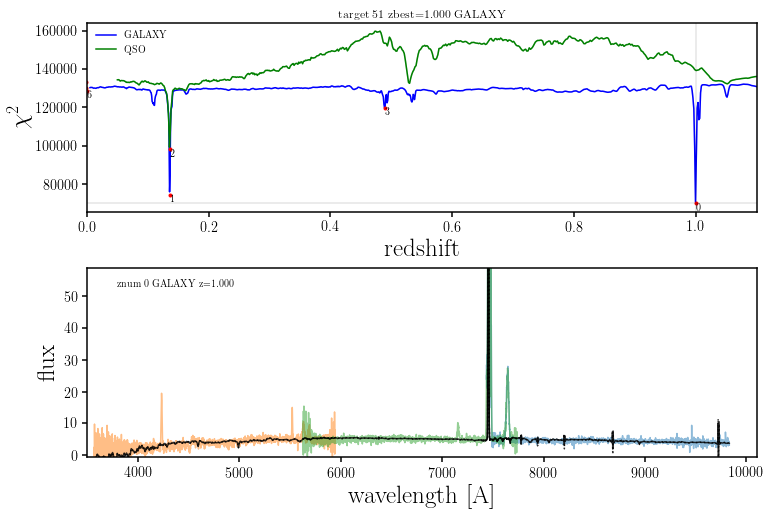

w/ Bright Sky


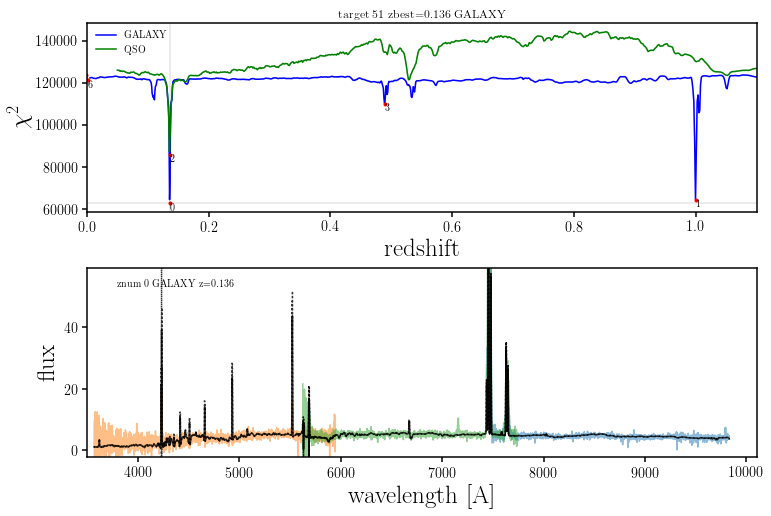

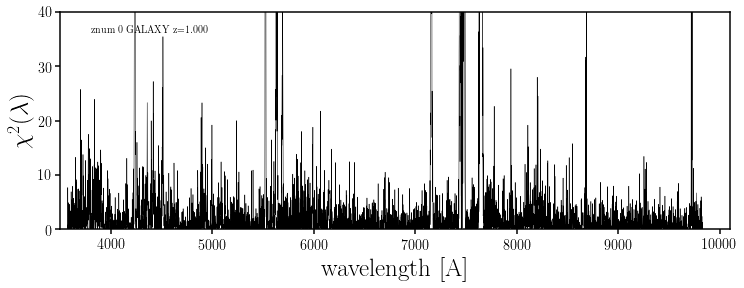

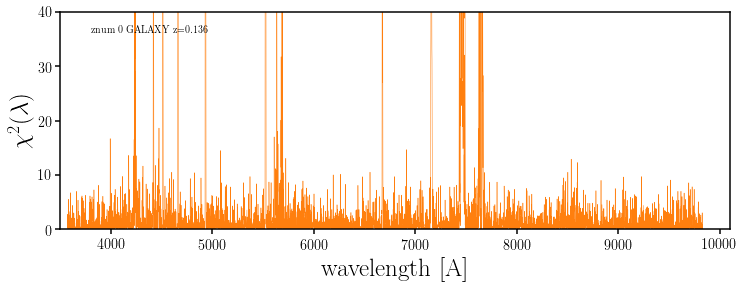

In [22]:
igal = np.arange(len(i_dark))[zfail_onlydark][0]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))
print('w/ Dark Sky')
plotspec(target_dark[igal], zscan_dark, zfit_dark, xrange0=[0.,1.1])
print('w/ Bright Sky')
plotspec(target_bright[igal], zscan_bright, zfit_bright, xrange0=[0.,1.1])

chi2_lambda(target_dark[igal], zscan_dark, zfit_dark, yrange=[0.,40.], color='k', lw=0.5)
chi2_lambda(target_bright[igal], zscan_bright, zfit_bright, yrange=[0.,40.], color='C1', lw=0.5)


(0.0, 0.4)

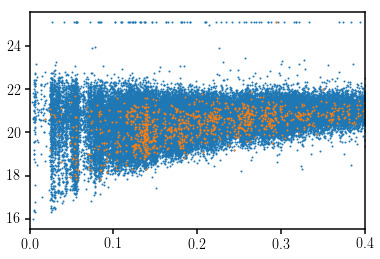

In [23]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(redshift, r_mag_legacy_apflux, c='C0', s=1)
sub.scatter(redshift[i_dark], r_mag_legacy_apflux[i_dark], c='C1', s=1)
sub.set_xlim([0., 0.4])

In [24]:
mag_cut = (r_mag_legacy_apflux[i_dark] < 25.)

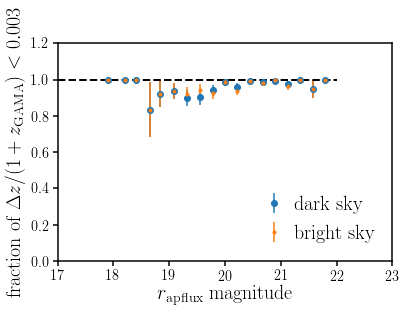

In [25]:
mm_dark, e1_dark, ee1_dark = UT.zeff_hist(r_mag_legacy_apflux[i_dark][mag_cut], 
                                          redshift[i_dark][mag_cut], 
                                          zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = UT.zeff_hist(r_mag_legacy_apflux[i_dark][mag_cut], 
                                                redshift[i_dark][mag_cut], 
                                                zbright_data['Z'][mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([17., 22.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub.set_xlim([17., 23.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})

In [29]:
zfail_dark_highr = ((np.abs(redshift[i_dark] - zdark_data['Z'])/redshift[i_dark] > 0.003) & 
                    (r_mag_legacy_apflux[i_dark] < 19.))

print('for %i galaxies with high apflux r-mag w/ dark sky redrock fails' % np.sum(zfail_dark_highr))

for 13 galaxies with high apflux r-mag w/ dark sky redrock fails


In [39]:
print('Delta z', np.abs(redshift[i_dark] - zdark_data['Z'])[zfail_dark_highr])

('Delta z', array([2.97041967e-04, 3.81156868e-04, 2.37416787e-04, 5.12877254e-04,
       2.31207789e-04, 2.86920854e-04, 2.75626339e-04, 8.44979973e-01,
       7.93748612e-04, 9.53837206e-01, 9.51798746e-01, 2.68886341e-04,
       3.35805079e-04]))


i = 613 with z_true = 0.103854, z_redrock = 0.948834


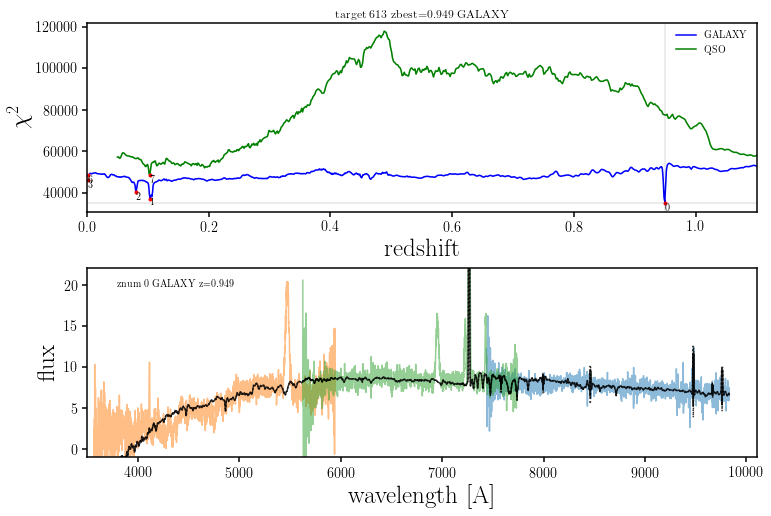

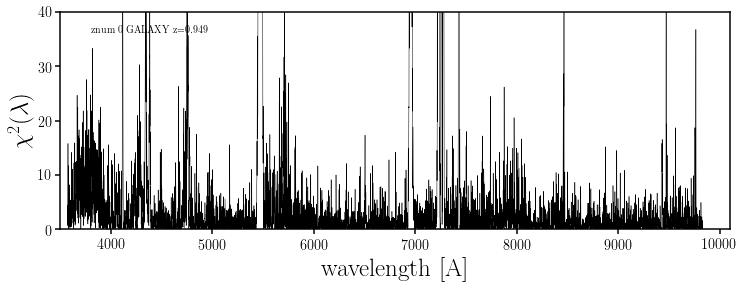

In [38]:
igal = np.arange(len(i_dark))[zfail_dark_highr][7]
print('i = %i with z_true = %f, z_redrock = %f' % (igal, redshift[i_dark][igal], zdark_data['Z'][igal]))
plotspec(target_dark[igal], zscan_dark, zfit_dark, xrange0=[0.,1.1])

_ = chi2_lambda(target_dark[igal], zscan_dark, zfit_dark, yrange=[0.,40.], color='k', lw=0.5)

i = 709 with z_true = 0.184611, z_redrock = 1.138448


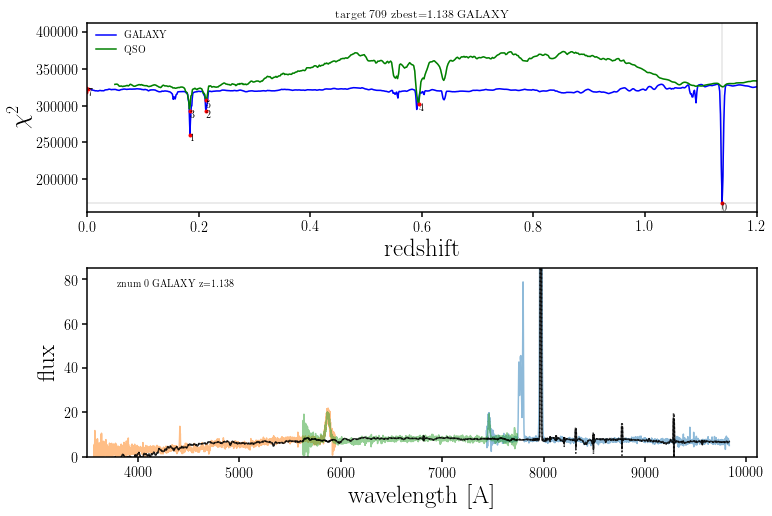

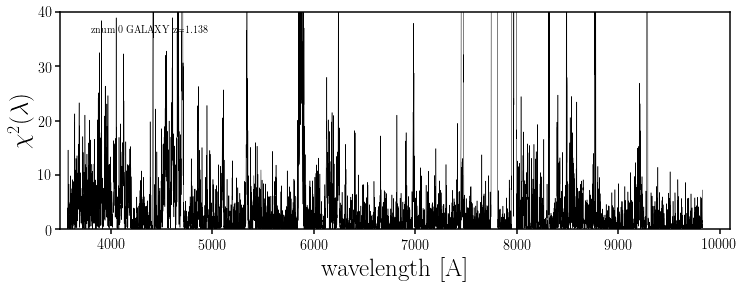

In [41]:
igal = np.arange(len(i_dark))[zfail_dark_highr][9]
print('i = %i with z_true = %f, z_redrock = %f' % (igal, redshift[i_dark][igal], zdark_data['Z'][igal]))
plotspec(target_dark[igal], zscan_dark, zfit_dark, xrange0=[0.,1.2])

_ = chi2_lambda(target_dark[igal], zscan_dark, zfit_dark, yrange=[0.,40.], color='k', lw=0.5)

In [42]:
zfail_bright_highr = ((np.abs(redshift[i_dark] - zbright_data['Z'])/redshift[i_dark] > 0.003) & 
                    (r_mag_legacy_apflux[i_dark] < 19.))

print('for %i galaxies with high apflux r-mag w/ bright sky redrock fails' % 
      np.sum(zfail_bright_highr))

for 15 galaxies with high apflux r-mag w/ bright sky redrock fails


In [43]:
print('Delta z', np.abs(redshift[i_dark] - zbright_data['Z'])[zfail_bright_highr])

('Delta z', array([2.88365524e-04, 3.18443743e-04, 2.70780006e-04, 5.08220087e-04,
       2.49723754e-04, 1.47470668e-04, 2.81094396e-04, 2.75784374e-04,
       1.86033542e-04, 8.45006540e-01, 9.18353921e-04, 9.53807650e-01,
       9.51878807e-01, 2.83594369e-04, 3.03604392e-04]))


i = 613 with z_true = 0.103854, z_redrock = 0.948861


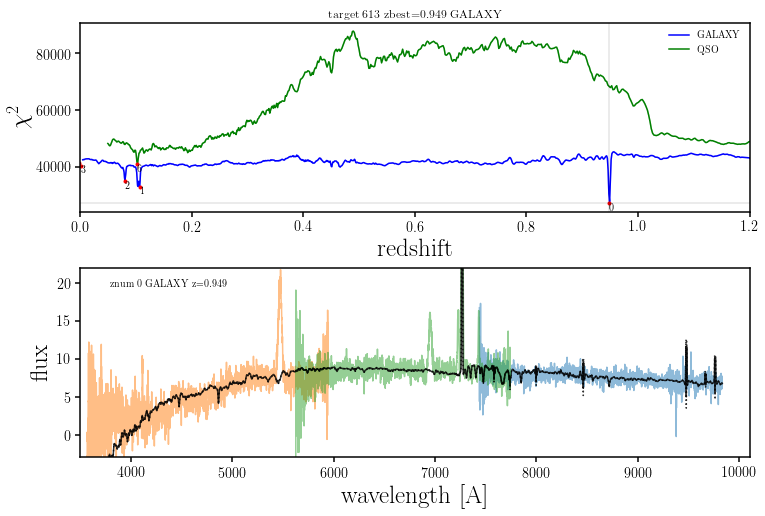

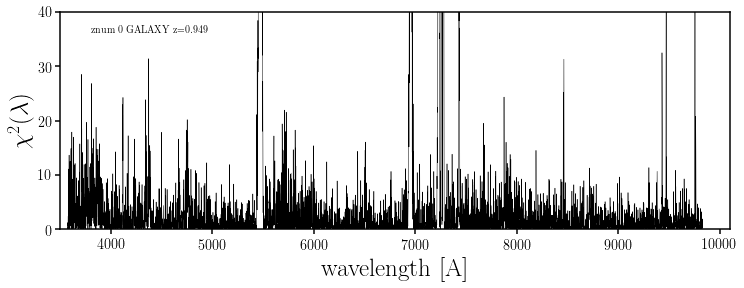

In [47]:
igal = np.arange(len(i_dark))[zfail_bright_highr][9]
print('i = %i with z_true = %f, z_redrock = %f' % (igal, redshift[i_dark][igal], zbright_data['Z'][igal]))
plotspec(target_bright[igal], zscan_bright, zfit_bright, xrange0=[0.,1.2])
_ = chi2_lambda(target_bright[igal], zscan_bright, zfit_bright, yrange=[0.,40.], color='k', lw=0.5)